In [1]:
import json
import pandas as pd
import re
import numpy as np
import torch
import random
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizerFast, BertForSequenceClassification
from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from IPython.display import clear_output
from torch.nn import DataParallel
import time
from tqdm import tqdm

In [2]:
from yes_no_dataset import YesNoAnswerDataset, simplify_nq_example
from yes_no_model import YesNoAnswerModel

### Read & Prepare Data

In [3]:
def read_json(filename):
    with open(filename, 'r') as json_file:
        json_list = list(json_file)
        
    data = []
    for json_str in json_list:
        data.append(json.loads(json_str))
    return data

In [4]:
train_data = read_json("v1.0-simplified_simplified-nq-train.jsonl")
dev_data = read_json("v1.0-simplified_nq-dev-all.jsonl")

In [5]:
val_data, test_data = train_test_split(dev_data, test_size=0.4, random_state=42)

In [6]:
tokenizer = BertTokenizerFast.from_pretrained('bert-base-cased')

In [7]:
max_len = 500

dataset_train = YesNoAnswerDataset(train_data, simplify_nq_example, tokenizer, max_len, should_simplify=False, balance=True, test=False)
dataset_val = YesNoAnswerDataset(val_data, simplify_nq_example, tokenizer, max_len, should_simplify=True, balance=False, test=False)
dataset_test = YesNoAnswerDataset(test_data, simplify_nq_example, tokenizer, max_len, should_simplify=True, balance=False, test=True)

100%|██████████████████████████████████████████████████████████████████████████████| 3132/3132 [00:27<00:00, 112.83it/s]


In [8]:
bs = 32
train_dataloader = DataLoader(dataset_train, batch_size=bs, shuffle=True)
val_dataloader = DataLoader(dataset_val, batch_size=bs, shuffle=True)

In [9]:
print(f"Training Steps: {len(train_dataloader)}")
print(f"Validation Steps: {len(val_dataloader)}")

Training Steps: 244
Validation Steps: 71


### Load model

In [19]:
model = BertForSequenceClassification.from_pretrained(
    'bert-base-uncased',
    num_labels = 3
)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [20]:
# freeze all BERT layers except for last two

for name, param in model.named_parameters():
    if name.startswith("classifier") or name.startswith("bert.encoder.layer.11") or name.startswith("bert.encoder.layer.10"): 
        continue
    else:
        param.requires_grad = False

In [21]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [22]:
lr = 1e-05
optimizer = torch.optim.Adam(params=model.parameters(), lr=lr)

In [23]:
answer_model = YesNoAnswerModel(model, device=device)

### Train

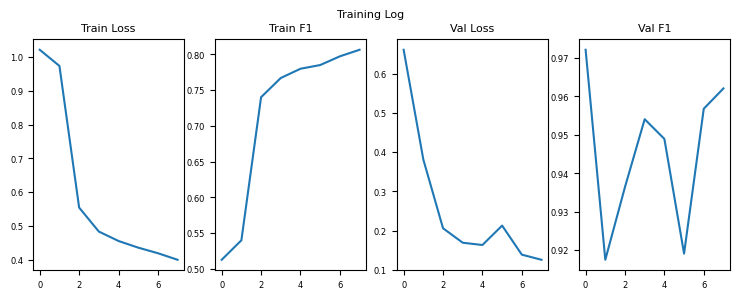

Epoch 7
Train loss: 0.400
Train micro F1: 0.807
Validation loss: 0.126
Validation micro F1: 0.962
Epoch time: 308.064s


In [24]:
answer_model.train(train_dataloader, val_dataloader, 8, optimizer, checkpoint_step=50, model_save_name='yes_no_model.pt')

### Test

In [25]:
test_dataloader = DataLoader(dataset_test, batch_size=1, shuffle=False)

In [26]:
label_dict = {"NO": 0, "YES": 1, "NONE": 2}
gold = []

for ex in test_data:
    long_answer_info = ex['annotations'][0]['long_answer']
    if long_answer_info['candidate_index'] == -1:
        continue
    ans = ex['annotations'][0]['yes_no_answer']
    gold.append(label_dict[ans])

In [28]:
pred = []

for batch in tqdm(test_dataloader):
    encoding = batch
    answer = answer_model(encoding['input_ids'][0], encoding['attention_mask'][0])
    pred.append(int(answer[0]))

100%|███████████████████████████████████████████████████████████████████████████████| 1504/1504 [00:49<00:00, 30.65it/s]


In [32]:
len(pred), len(gold)

(1504, 1504)

In [30]:
print(f"F score: {f1_score(pred, gold, average='micro'):.4f}")

F score: 0.9574


In [31]:
print("Majority baseline")
print(f"F score: {f1_score([2]*len(gold), gold, average='micro'):.4f}")

Majority baseline
F score: 0.9767
